In [1]:
import itertools
from IPython.display import clear_output, display

In [2]:
import numpy as np
import scipy
import scipy.stats

import matplotlib.pyplot as plt

In [3]:
import torch as t
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, BatchNorm1d
import torchvision

In [4]:
%matplotlib inline

In [5]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

## MNIST 

In [6]:
dl_train = t.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=True, download=True))

dl_test  = t.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=False, download=True))

In [7]:
mnist_train_data   = dl_train.dataset.data.to(dtype=t.float32)
mnist_train_labels = dl_train.dataset.targets

In [8]:
mnist_test_data   = dl_test.dataset.data.to(dtype=t.float32)
mnist_test_labels = dl_test.dataset.targets

In [9]:
mnist_data = np.concatenate((mnist_train_data, mnist_test_data))
mnist_labels = np.concatenate((mnist_train_labels, mnist_test_labels))

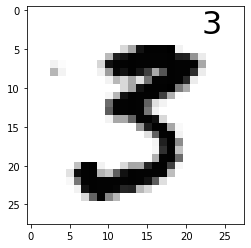

In [10]:
index=49
plt.imshow(mnist_data[index], cmap='Greys')
plt.text(22,3,'%d' % (mnist_labels[index],), fontsize=32);

In [11]:
mnist_data_flatened = 2*mnist_data.astype('float32').reshape(-1,28*28)/255.0 - 1.0
np.random.shuffle(mnist_data_flatened)
mnist_data_t = t.from_numpy(mnist_data_flatened[0:10000])

I am taking the whole data set. But if you run on the CPU you can consider using a smaller portion e.g 
```
mnist_data_t = t.from_numpy(mnist_data_flatened[0:20000])
```

## Models

In [12]:
def init_layer(layer):
    if isinstance(layer,t.nn.modules.linear.Linear):
        fan_in = layer.weight.size(1)
        sigma = 1*np.sqrt(6/fan_in)
        t.nn.init.uniform_(layer.weight,-sigma,sigma)
        if layer.bias is not None:
            t.nn.init.zeros_(layer.bias)

In [13]:
def init_layer_with_sigma(sigma=1):
    def f(layer):
        if isinstance(layer,t.nn.modules.linear.Linear):
            fan_in = layer.weight.size(1)
            s = sigma*np.sqrt(6/fan_in)
            t.nn.init.uniform_(layer.weight, -s , s)
            if layer.bias is not None:
                t.nn.init.zeros_(layer.bias)
    return f            

### Discriminator

In [14]:
discriminator = Sequential(Linear(28*28,1024), 
                           LeakyReLU(0.2, inplace=True),
                           t.nn.Dropout(0.3),
                           Linear(1024,512), 
                           LeakyReLU(0.2, inplace=True),
                           t.nn.Dropout(0.3),
                           Linear(512,256), 
                           LeakyReLU(0.2, inplace=True),
                           t.nn.Dropout(0.3),
                           Linear(256,1), 
                           t.nn.Sigmoid()
                                     )

### Generator

In [15]:
def make_generator(noise_input_size):
    return Sequential( Linear(noise_input_size,256), BatchNorm1d(256), LeakyReLU(0.2, inplace=True),
                       Linear(256,512),   BatchNorm1d(512), LeakyReLU(0.2, inplace=True),
                       Linear(512,1024), BatchNorm1d(1024), LeakyReLU(0.2, inplace=True),
                       Linear(1024,28*28), t.nn.Tanh()
                         )

In [16]:
noise_input_size = 100
generator = make_generator(noise_input_size)

In [17]:
discriminator.apply(init_layer_with_sigma(1.0))

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=256, out_features=1, bias=True)
  (10): Sigmoid()
)

In [18]:
generator.apply(init_layer_with_sigma(1.0))

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Linear(in_features=1024, out_features=784, bias=True)
  (10): Tanh()
)

Move data and models to the device (CUDA). 

In [19]:
mnist_data_t = mnist_data_t.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

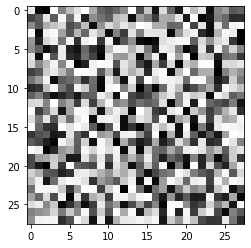

In [20]:
with t.no_grad():
    generator.eval()
    in_t = t.empty(1,noise_input_size, device=device).uniform_(-1,1)
    out_t = generator(in_t);
    plt.imshow(out_t.data.cpu().numpy().reshape(28,28), cmap='Greys')

Binary Cross Entropy loss with labels $l_i$ is defined as:
$$bce(\{ p_i \},\{ l_ i\}) = \frac{1}{n}\sum_{i=0}^{n-1} \left(l_i \log p_i + (1-l_i) \log(1-p_i)\right)  $$

In [21]:
bce = t.nn.BCELoss()

Functions below implement a non-saturating loss function for generator and  one-sided label smoothing  for discriminator.

In [22]:
def discriminator_loss(imgs):
    data_size = len(imgs)
    
    real_labels = t.ones(data_size,1, device=device)
    d_real_loss = bce(discriminator(imgs), 0.9*real_labels) #Using one-sided label smoothing
    fake_labels = t.zeros(data_size,1, device=device)
    z = t.empty(data_size, noise_input_size, device=device).uniform_(-1,1)
    g_out = generator(z).detach()
    d_fake_loss = bce(discriminator(g_out), fake_labels)
    
    d_loss = d_fake_loss + d_real_loss
    return d_loss 
    
def generator_loss(data_size):    
    z = t.empty(data_size, noise_input_size, device=device).uniform_(-1,1)
    g_out = generator(z)
    real_labels = t.ones(data_size,1, device=device)
    g_loss = bce(discriminator(g_out), real_labels)
    return g_loss

In [23]:
with t.no_grad():
              d_loss = discriminator_loss(mnist_data_t)
              g_loss = generator_loss(len(mnist_data_t)) 
print(d_loss.item(), g_loss.item())

1.9641155004501343 1.4459387063980103


In [24]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0004,betas=(0.5, 0.999))
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [25]:
generator.train()

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Linear(in_features=512, out_features=1024, bias=True)
  (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Linear(in_features=1024, out_features=784, bias=True)
  (10): Tanh()
)

In [ ]:
import time
start = time.time()

cols = 8
rows = 4 

fixed_noise = t.empty(cols*rows,noise_input_size, device=device).uniform_(-1,1)

k_discriminator = 2
k_generator = 1
if device.type == 'cpu':
    mini_batch_size=64
else:
    mini_batch_size=2048
n_epochs = 200

generator.train()

for epoch in range(1,n_epochs+1):
    for k in range(len(mnist_data_t)//mini_batch_size):
        for di in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(mnist_data_t)//mini_batch_size )
            d_loss= discriminator_loss(mnist_data_t[kr*(mini_batch_size):(kr+1)*(mini_batch_size)])
                             
            d_loss.backward()
            d_optimizer.step()
        for gi in range(k_generator):
            g_optimizer.zero_grad()
            g_loss = generator_loss(mini_batch_size)
            g_loss.backward()
            g_optimizer.step()
    if epoch % 1 == 0:
        clear_output(wait=True)
        with t.no_grad():           
            d_loss = discriminator_loss(mnist_data_t)
            g_loss = generator_loss(len(mnist_data_t)) 
        end = time.time()
        ellapsed = end - start
        time_per_epoch = ellapsed/epoch
        eta = time_per_epoch*(n_epochs-epoch)
        print('%5d %6.2f %6.2f %6.2fs %6.2fs\n' % (epoch, d_loss.item(), g_loss.item(), ellapsed, eta))
        fig, ax = plt.subplots(rows, cols, figsize=(1.5*cols,1.5*rows))
        with t.no_grad():
            # Generate the row x cols samples always using same noise for each of them. 
            generator.eval()
            out_t = generator(fixed_noise);
            #Plot the samples on rows x cols grid. 
            for i, j in itertools.product(range(rows), range(cols) ):
                ax[i,j].get_xaxis().set_visible(False)
                ax[i,j].get_yaxis().set_visible(False)
            for i, j in itertools.product(range(rows), range(cols)):    
                ax[i,j].imshow(out_t[i*cols+j].cpu().data.numpy().reshape(28,28), cmap='Greys')  
            plt.savefig("img/_%03d.png" % (epoch,))
            plt.close() #This prevents plt from displaying the picture in the notebook. 
            generator.train();

    6   0.90   2.59 115.59s 3737.48s



In [ ]:
#save the generator
t.save(generator.state_dict(),"gan.pt")

In [ ]:
#display the samples
with t.no_grad():
    # Generate the row x cols samples always using same noise for each of them. 
    generator.eval()
    out_t = generator(fixed_noise);
    #Plot the samples on rows x cols grid. 
    fig, ax = plt.subplots(rows, cols, figsize=(1.5*cols,1.5*rows))
    for i, j in itertools.product(range(rows), range(cols) ):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for i, j in itertools.product(range(rows), range(cols)):    
        ax[i,j].imshow(out_t[i*cols+j].cpu().data.numpy().reshape(28,28), cmap='Greys')         

In [ ]:
#Display original data
cols = 8
rows = 4 
fig, ax = plt.subplots(rows, cols, figsize=(1.5*cols,1.5*rows))
for i, j in itertools.product(range(rows), range(cols) ):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
for i, j in itertools.product(range(rows), range(cols)):  
    ax[i,j].imshow(mnist_data[np.random.randint(0,len(mnist_data))], cmap='Greys')    

A demonstration of how to load generator.  

In [ ]:
generator_loaded = make_generator(noise_input_size)

In [ ]:
generator_loaded.load_state_dict(t.load('gan.pt'))
generator_loaded.eval()

In [ ]:
generator_loaded= generator_loaded.to(device)

In [ ]:
in_t = t.empty(1,noise_input_size, device=device).uniform_(-1,1)
out_t = generator_loaded(in_t);
plt.imshow(out_t.cpu().data.numpy().reshape(28,28), cmap='Greys')